In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import shap
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from sklearn.metrics import roc_curve, roc_auc_score

## Load the data 🎉😎🧬

In [ ]:
notebook_dir = os.getcwd()
print(f"Current notebook directory: {notebook_dir}")
features_file = notebook_dir + '/data/filtered_combined_data.tsv'
#labels_file = os.path.join(notebook_dir, '../data/toy_labels.tsv')

features_df = pd.read_csv(features_file, sep='\t', index_col=0)
#labels_df = pd.read_csv(labels_file, sep='\t', index_col=0)

labels = pd.Series([0 if col.startswith('N') else 1 for col in features_df.columns], index=features_df.columns)

# Convert to DataFrame if needed
label_df = labels.to_frame(name='label')

Current notebook directory: /Users/deeptimurthy/BENG203
Features file path: /Users/deeptimurthy/BENG203/data/filtered_combined_data.tsv


## Set up for cross validation 👁👄👁

In [24]:
SEED = 33
X = features_df.T.loc[labels_df.index]
y = labels_df['label'].values
num_splits = 5
cv = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=SEED)

## Train a Random Forest 🌲🌳📉

In [29]:
# Store results
accuracies = []
shap_values_all = []
explainer = None

for fold, (train_idx, test_idx) in tqdm(enumerate(cv.split(X, y), 1), total=num_splits, desc='Cross-validation'):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Train model
    #model = RandomForestClassifier(random_state=SEED) # change the model here
    model = LogisticRegression(random_state=SEED, max_iter=1000)  # Example model
    model.fit(X_train, y_train)

    # Predict and evaluate
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    accuracies.append(acc)
    print(f"Fold {fold} Accuracy: {acc:.4f}")

    # Save metrics for fold one
    if fold == 1:
        # SHAP
        explainer = shap.Explainer(model, X_train)
        shap_values = explainer(X_test)
        shap_values_all.append(shap_values)

        # AUROC
        probs = model.predict_proba(X_test)[:, 1]
        first_fold_y_true = y_test
        first_fold_y_probs = probs

# Summary of performance
print(f"\nMean Accuracy 🫡: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")

Cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]


NameError: name 'LogisticRegression' is not defined

## SHAP evaluation 🧐📈⚖️

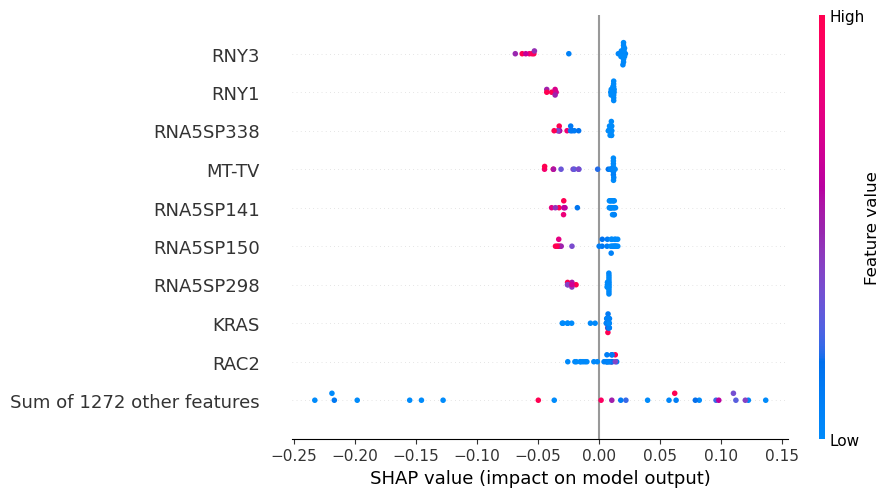

In [26]:
# SHAP summary plot for first fold (class 1 in binary classification)
if shap_values_all:
    shap.plots.beeswarm(shap_values_all[0][:, :, 1])

## AUROC 😱✨⁉️

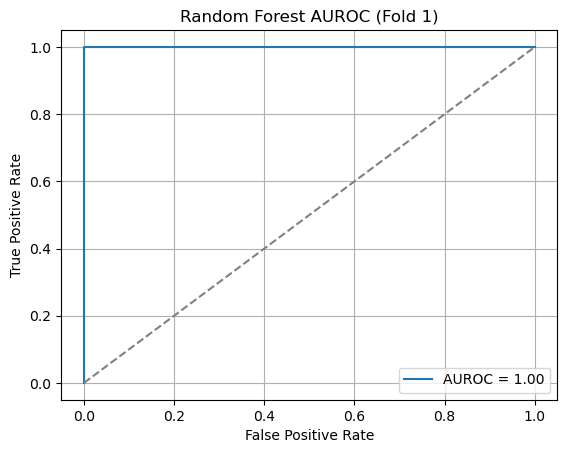

In [27]:
fpr, tpr, _ = roc_curve(first_fold_y_true, first_fold_y_probs)
auc = roc_auc_score(first_fold_y_true, first_fold_y_probs)

plt.figure()
plt.plot(fpr, tpr, label=f'AUROC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest AUROC (Fold 1)')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
print(f"\"probs\": [{', '.join([str(p) for p in probs])}],")
print(f"\"first_fold_y_true\": [{', '.join([str(p) for p in first_fold_y_true])}],")
print(f"\"first_fold_y_probs\": [{', '.join([str(p) for p in first_fold_y_probs])}]")

"probs": [0.24, 0.37, 0.23, 0.28, 0.22, 0.3, 0.34, 0.9, 0.97, 0.86, 0.89, 0.82, 0.9, 0.96, 0.8, 0.96, 0.96, 0.78, 0.89, 0.91, 0.78, 0.9, 0.87, 0.91, 0.8, 0.92],
"first_fold_y_true": [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
"first_fold_y_probs": [0.24, 0.37, 0.23, 0.28, 0.22, 0.3, 0.34, 0.9, 0.97, 0.86, 0.89, 0.82, 0.9, 0.96, 0.8, 0.96, 0.96, 0.78, 0.89, 0.91, 0.78, 0.9, 0.87, 0.91, 0.8, 0.92]
